In [9]:
# Cell 1 - Title
# ARES BO Prior Results Visualization

In [10]:
# Cell 2 - Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    import scienceplots
    plt.style.use(["science", "ieee", "no-latex"])
except ImportError: 
    print("scienceplots not installed, using default style")
    plt.style.use('seaborn-v0_8-darkgrid')

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [11]:
# Cell 3 - load csv
## Load Data

df_nm_mismatched = pd.read_csv("data/NM_mismatched.csv")
df_bo_mismatched = pd.read_csv("data/BO_mismatched.csv")
df_bo_prior_mismatched = pd.read_csv("data/BO_prior_mismatched.csv")
df_bo_prior_matched_newtask = pd.read_csv("data/BO_prior_matched_prior_newtask.csv")

print("Available columns:")
print(df_bo_mismatched.columns.tolist())


Available columns:
['step', 'q1', 'q2', 'q3', 'cv', 'ch', 'mse', 'log_mse', 'mae', 'log_mae', 'xopt_runtime', 'xopt_error', 'run', 'best_mae']


In [12]:
# Cell 4 - Diagnostics
print("=== DEBUGGING BO_PRIOR ISSUES ===\n")

# Redefine all_dfs
all_dfs = [df_nm_mismatched, df_bo_mismatched, df_bo_prior_mismatched, df_bo_prior_matched_newtask]

# 1.Check if misalignment columns exist
print("1.Checking for misalignment columns:")
misalign_cols = [col for col in df_bo_prior_mismatched.columns if 'misalign' in col]
if misalign_cols:
    print(f"   ✓ Found {len(misalign_cols)} misalignment columns:  {misalign_cols[: 3]}...")
    print(f"   Sample values from last step:")
    last_row = df_bo_prior_mismatched.iloc[-1]
    for col in misalign_cols[: 3]:
        print(f"     {col}: {last_row[col]:.6e}")
else:
    print("   ✗ NO MISALIGNMENT COLUMNS FOUND!")

# 2.Check runtime per step
print("\n2.Average runtime per step:")
method_names = ['NM', 'BO', 'BO_prior (mis)', 'BO_prior (match)']
for name, df in zip(method_names, all_dfs):
    if 'xopt_runtime' in df.columns:
        avg_time = df['xopt_runtime'].mean()
        print(f"   {name:<20s}: {avg_time:.2f} seconds/step")
    else:
        print(f"   {name:20s}:  no runtime data")

# 3.Check convergence
print("\n3.Did BO_prior improve? ")
if len(df_bo_prior_mismatched) > 0:
    initial = df_bo_prior_mismatched['mae'].iloc[0]
    final = df_bo_prior_mismatched['best_mae'].iloc[-1]
    print(f"   Initial:   {initial:.6e}")
    print(f"   Final:    {final:.6e}")
    improvement = (initial - final) / initial * 100
    print(f"   Change:   {improvement:.1f}%")
    if improvement > 0:
        print("   ✓ Prior IS improving (good! )")
    else:
        print("   ✗ Prior is NOT improving")

# 4.Speed comparison
print("\n4.Speed comparison:")
bo_time = df_bo_mismatched['xopt_runtime'].mean() if 'xopt_runtime' in df_bo_mismatched.columns else 0
bo_prior_time = df_bo_prior_mismatched['xopt_runtime'].mean() if 'xopt_runtime' in df_bo_prior_mismatched.columns else 0
if bo_time > 0 and bo_prior_time > 0:
    slowdown = bo_prior_time / bo_time
    print(f"   BO_prior is {slowdown:.1f}x slower than BO")

print("\n=== END DIAGNOSTICS ===")

=== DEBUGGING BO_PRIOR ISSUES ===

1.Checking for misalignment columns:
   ✓ Found 6 misalignment columns:  ['q1_misalign_x', 'q1_misalign_y', 'q2_misalign_x']...
   Sample values from last step:
     q1_misalign_x: 4.507787e-06
     q1_misalign_y: -1.807049e-05
     q2_misalign_x: -1.348825e-06

2.Average runtime per step:
   NM                  : 0.02 seconds/step
   BO                  : 0.02 seconds/step
   BO_prior (mis)      : 0.02 seconds/step
   BO_prior (match)    : 0.02 seconds/step

3.Did BO_prior improve? 
   Initial:   9.779235e-04
   Final:    1.404877e-04
   Change:   85.6%
   ✓ Prior IS improving (good! )

4.Speed comparison:
   BO_prior is 1.1x slower than BO

=== END DIAGNOSTICS ===


In [13]:
# Cell 5 - 
## Summary Statistics - Best results summary

all_dfs = [df_nm_mismatched, df_bo_mismatched, df_bo_prior_mismatched, df_bo_prior_matched_newtask]

global_best_mae = min([df['mae'].min() for df in all_dfs])

print(f"Best MAE found across all methods: {global_best_mae:.6e}")

method_names = ['NM', 'BO', 'BO_prior (mismatched)', 'BO_prior (matched)']
print("\nBest result by method:")
for name, df in zip(method_names, all_dfs):
    best_val = df['mae'].min()
    print(f"{name:<30s}: {best_val:.6e}")
    if df['mae'].min() == global_best_mae:
        print(f"  ^^^ BEST OVERALL ^^^")

if 'q1_misalign_x' in df_bo_prior_mismatched.columns:
    print("\n=== Learned Misalignments (BO_prior mismatched, last trial) ===")
    last_run = df_bo_prior_mismatched[df_bo_prior_mismatched['run'] == df_bo_prior_mismatched['run'].max()]
    last_step = last_run[last_run['step'] == last_run['step'].max()]
    print(f"Q1: x={last_step['q1_misalign_x'].values[0]:.6f}m, y={last_step['q1_misalign_y'].values[0]:.6f}m")
    print(f"Q2: x={last_step['q2_misalign_x'].values[0]:.6f}m, y={last_step['q2_misalign_y'].values[0]:.6f}m")
    print(f"Q3: x={last_step['q3_misalign_x'].values[0]:.6f}m, y={last_step['q3_misalign_y'].values[0]:.6f}m")
    print("\nGround truth:")
    print("Q1: x=0.000000m, y=0.000100m")
    print("Q2: x=0.000030m, y=-0.000120m")
    print("Q3: x=-0.000040m, y=0.000080m")

Best MAE found across all methods: 6.682035e-05

Best result by method:
NM                            : 1.554869e-04
BO                            : 9.834349e-05
BO_prior (mismatched)         : 6.682035e-05
  ^^^ BEST OVERALL ^^^
BO_prior (matched)            : 1.013848e-04

=== Learned Misalignments (BO_prior mismatched, last trial) ===
Q1: x=0.000005m, y=-0.000018m
Q2: x=-0.000001m, y=-0.000017m
Q3: x=-0.000500m, y=-0.000500m

Ground truth:
Q1: x=0.000000m, y=0.000100m
Q2: x=0.000030m, y=-0.000120m
Q3: x=-0.000040m, y=0.000080m


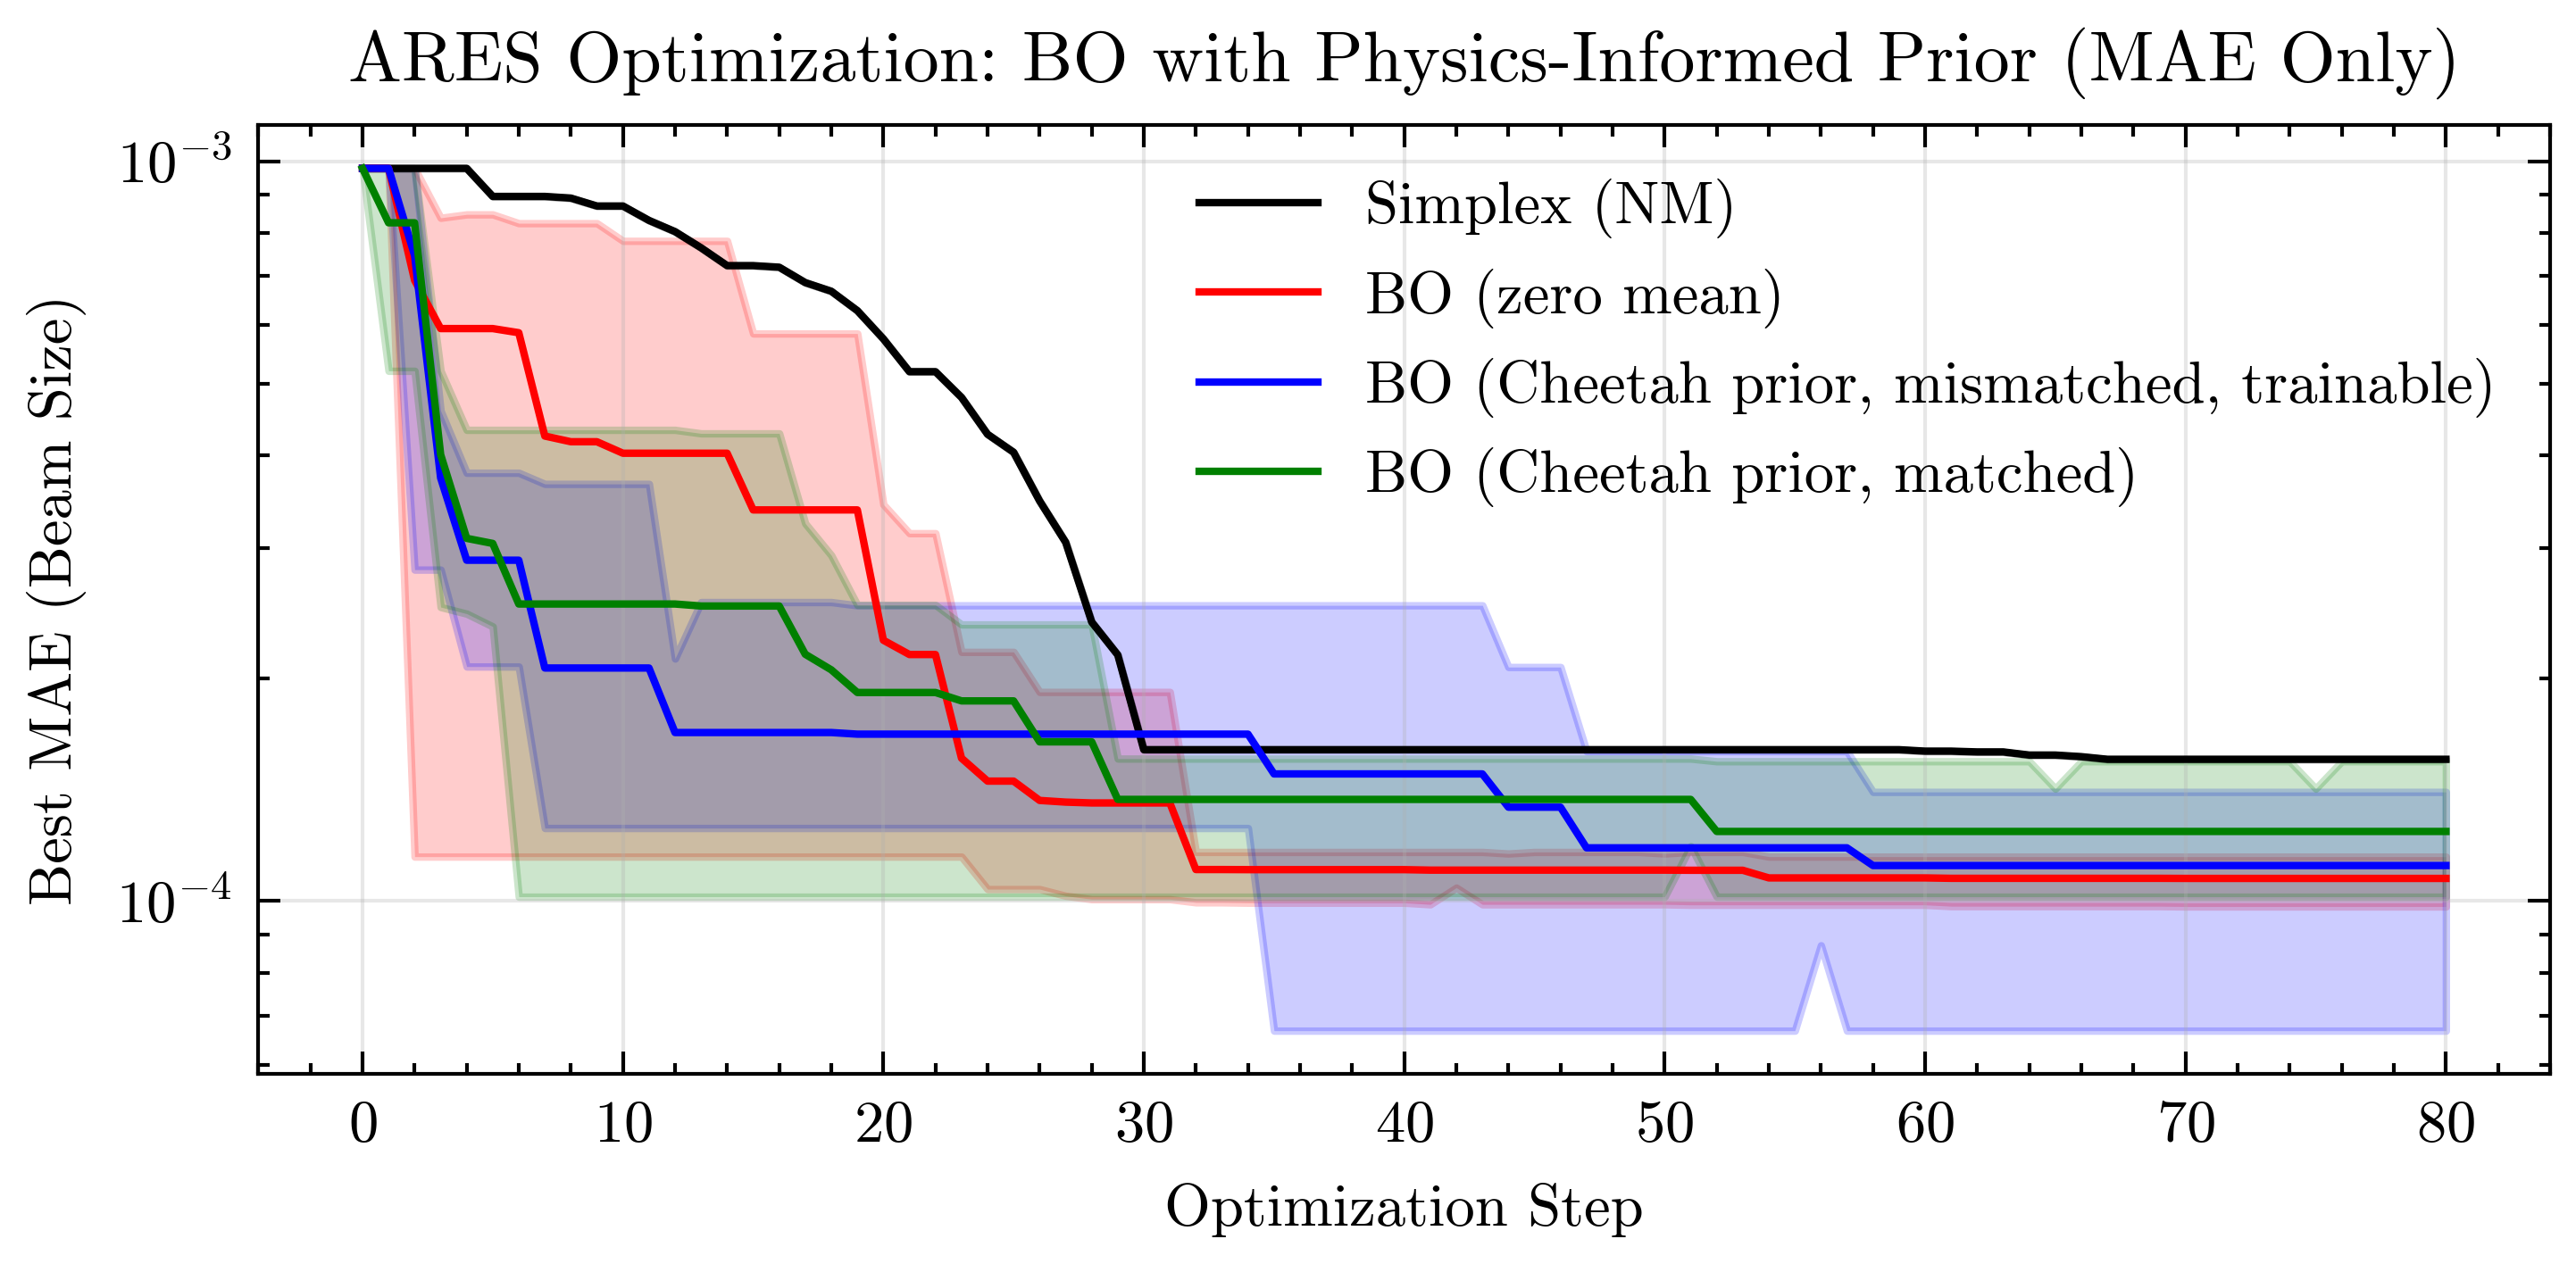

Convergence plot saved!


In [14]:
# Cell 6 -  Plot Convergence Curves

figsize = list(plt.rcParams["figure.figsize"])
figsize[0] *= 1.5
fig = plt.figure(figsize=figsize)
ax = plt.gca()

sns.lineplot(
    data=df_nm_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="Simplex (NM)",
    color=colors[0],
)

sns.lineplot(
    data=df_bo_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (zero mean)",
    color=colors[1],
)

sns.lineplot(
    data=df_bo_prior_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (Cheetah prior, mismatched, trainable)",
    color=colors[2],
)

sns.lineplot(
    data=df_bo_prior_matched_newtask,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (Cheetah prior, matched)",
    color=colors[3],
)

ax.set_xlabel("Optimization Step")
ax.set_ylabel("Best MAE (Beam Size)")
ax.set_title("ARES Optimization: BO with Physics-Informed Prior (MAE Only)")
ax.legend(loc="best")
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("ares_bo_prior_result_mae.pdf", dpi=300, bbox_inches='tight')
plt.savefig("ares_bo_prior_result_mae.png", dpi=300, bbox_inches='tight')
plt.show()

print("Convergence plot saved!")

In [15]:
# Cell 7 - Statistical Comparison

def get_final_best(df, metric='mae'):
    """Get the final best value for each run."""
    return df.groupby('run')[f'best_{metric}'].last()

nm_final = get_final_best(df_nm_mismatched)
bo_final = get_final_best(df_bo_mismatched)
bo_prior_mis_final = get_final_best(df_bo_prior_mismatched)
bo_prior_match_final = get_final_best(df_bo_prior_matched_newtask)

print("\n=== Final Performance Statistics (MAE - Beam Size) ===")
print(f"NM:                    mean={nm_final.mean():.6e}, std={nm_final.std():.6e}")
print(f"BO:                    mean={bo_final.mean():.6e}, std={bo_final.std():.6e}")
print(f"BO_prior (mismatched): mean={bo_prior_mis_final.mean():.6e}, std={bo_prior_mis_final.std():.6e}")
print(f"BO_prior (matched):    mean={bo_prior_match_final.mean():.6e}, std={bo_prior_match_final.std():.6e}")

improvement_mis = (bo_final.mean() - bo_prior_mis_final.mean()) / bo_final.mean() * 100
improvement_match = (bo_final.mean() - bo_prior_match_final.mean()) / bo_final.mean() * 100

print(f"\nImprovement over standard BO:")
print(f"  BO_prior (mismatched): {improvement_mis:.2f}%")
print(f"  BO_prior (matched):    {improvement_match:.2f}%")

if improvement_mis > 0:
    print("\n✓ BO_prior (mismatched) is BETTER than standard BO")
else:
    print("\n❌ BO_prior (mismatched) is WORSE than standard BO")



=== Final Performance Statistics (MAE - Beam Size) ===
NM:                    mean=1.554869e-04, std=0.000000e+00
BO:                    mean=1.073261e-04, std=8.349276e-06
BO_prior (mismatched): mean=1.117160e-04, std=3.939172e-05
BO_prior (matched):    mean=1.242124e-04, std=2.735024e-05

Improvement over standard BO:
  BO_prior (mismatched): -4.09%
  BO_prior (matched):    -15.73%

❌ BO_prior (mismatched) is WORSE than standard BO


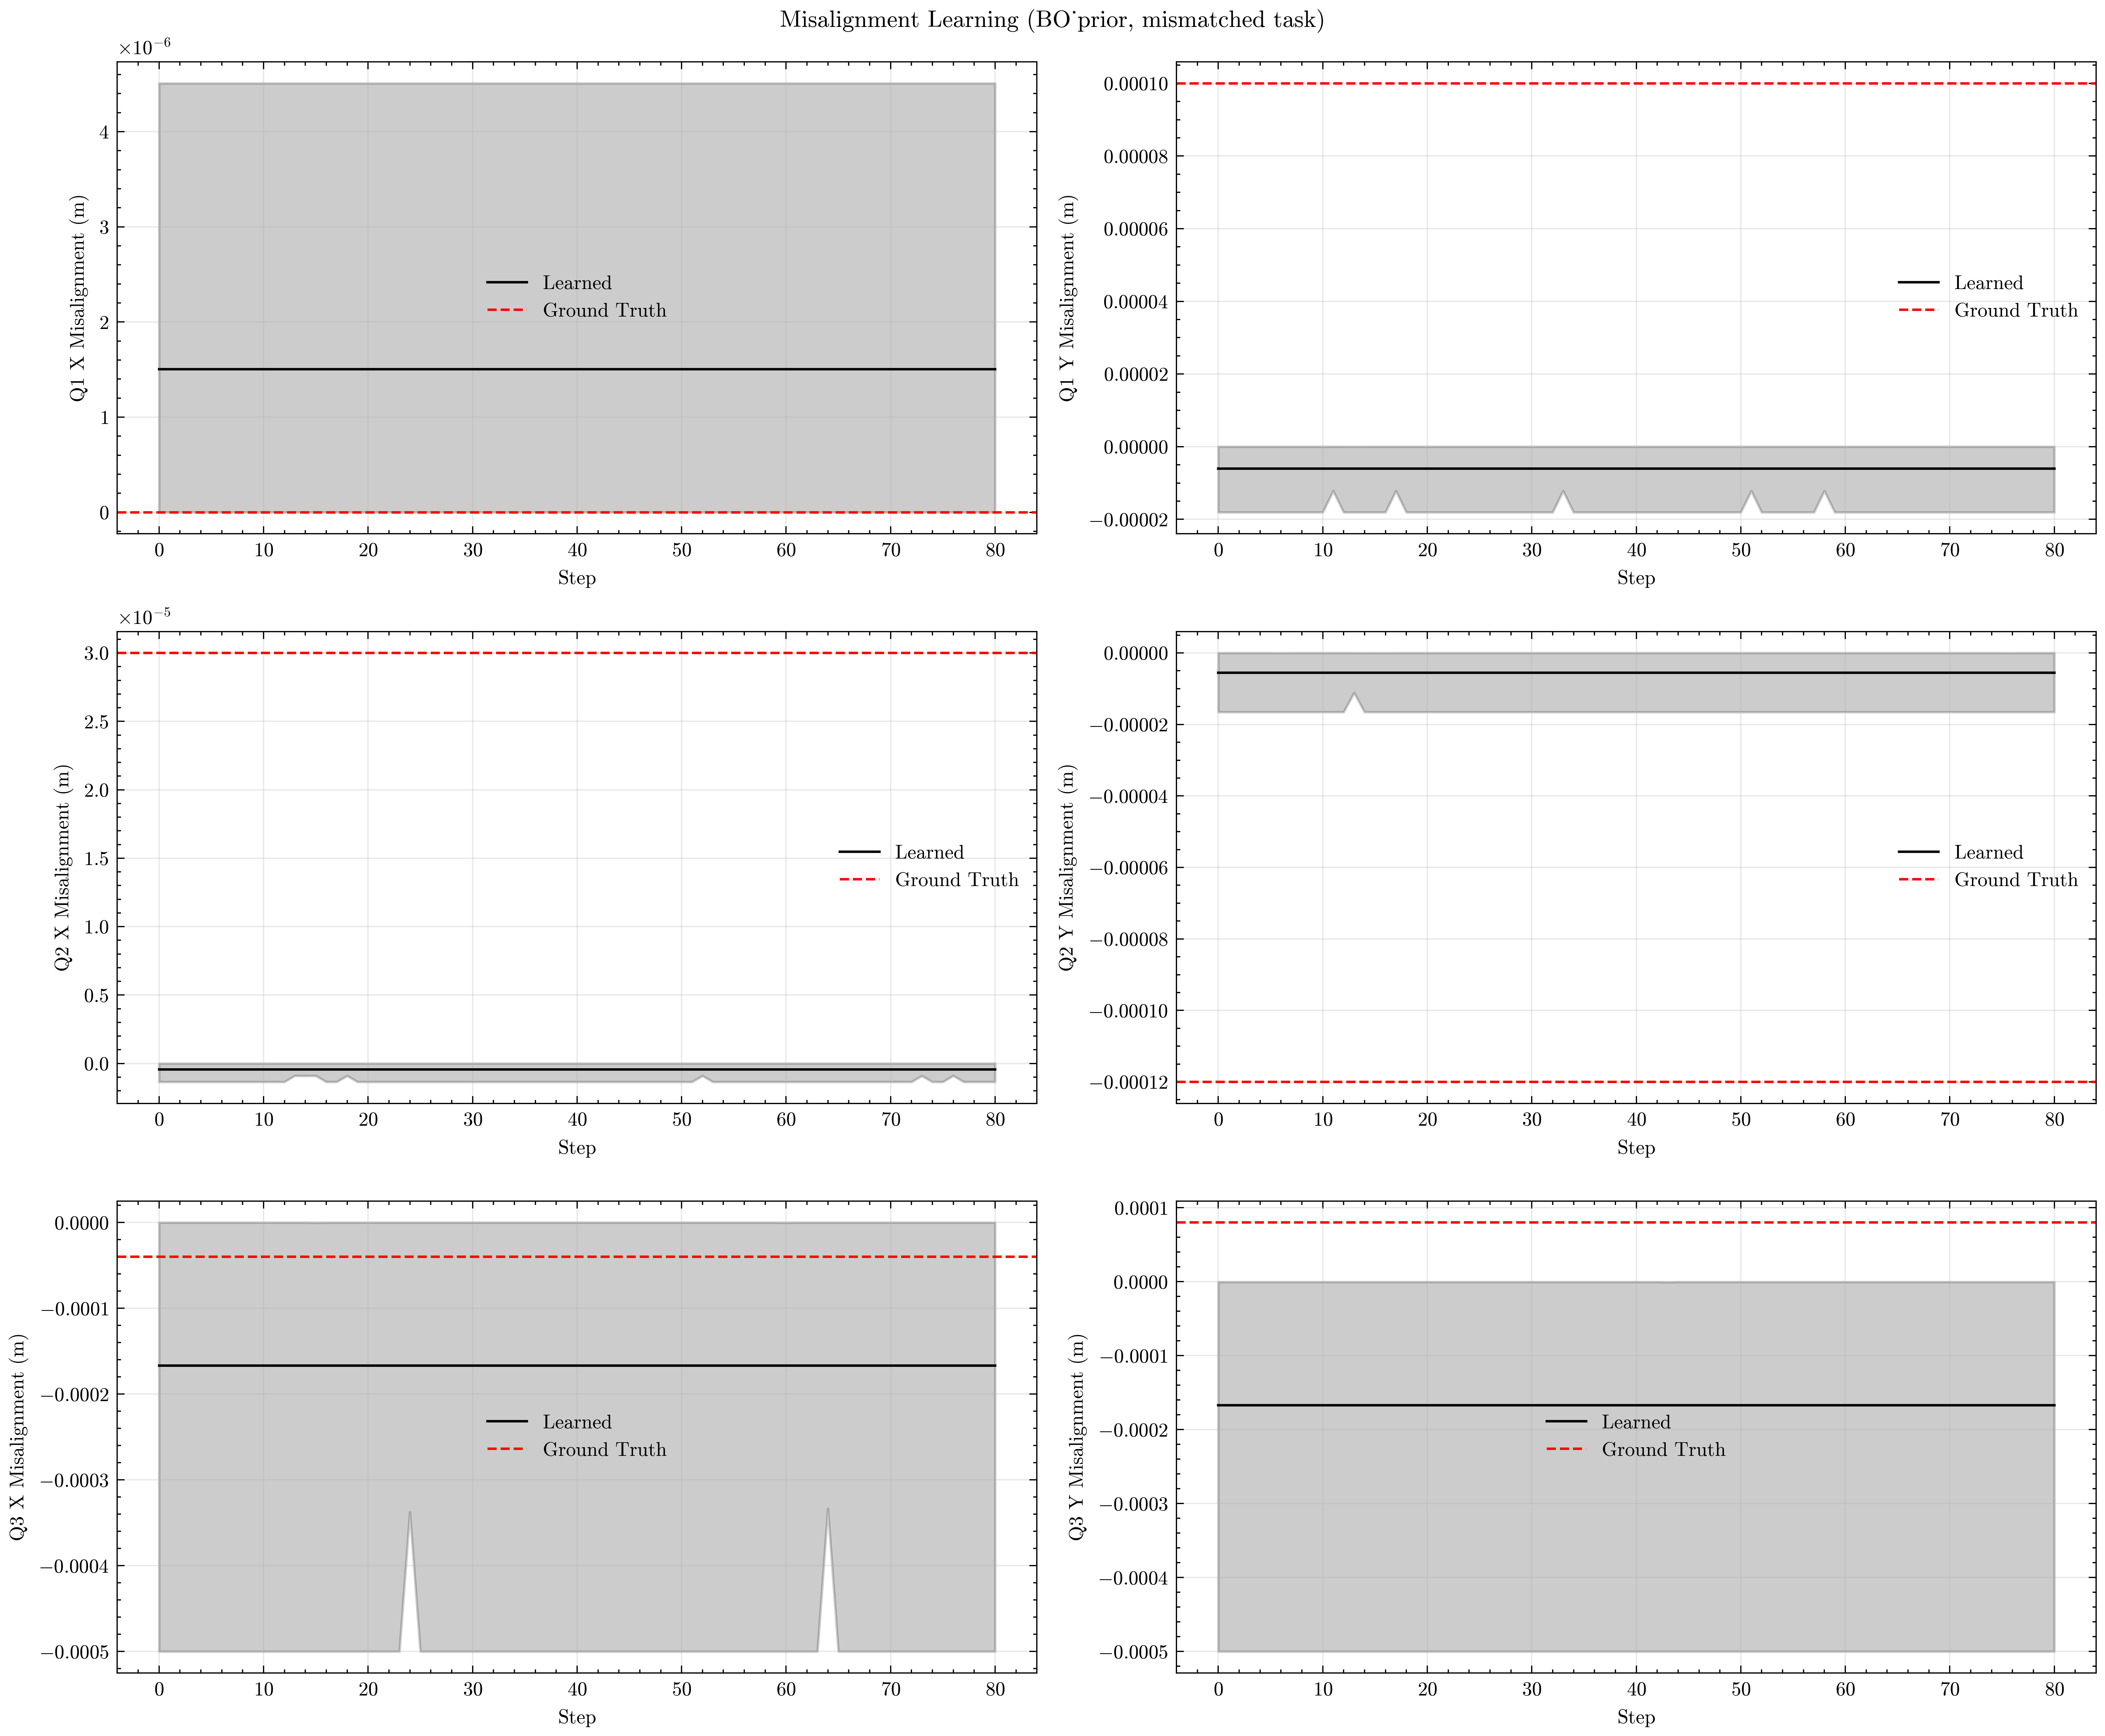

Misalignment learning plot saved!


In [16]:
# Cell 8 - Misalignment Learning Analysis

if 'q1_misalign_x' in df_bo_prior_mismatched.columns:
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    
    ground_truth = {
        'q1':  (0.000000, 0.000100),
        'q2': (0.000030, -0.000120),
        'q3': (-0.000040, 0.000080),
    }
    
    for i, quad in enumerate(['q1', 'q2', 'q3']):
        # X misalignment
        ax = axes[i, 0]
        sns.lineplot(
            data=df_bo_prior_mismatched,
            x="step",
            y=f"{quad}_misalign_x",
            ax=ax,
            label="Learned"
        )
        ax.axhline(ground_truth[quad][0], color='red', linestyle='--', label='Ground Truth')
        ax.set_ylabel(f"{quad.upper()} X Misalignment (m)")
        ax.set_xlabel("Step")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Y misalignment
        ax = axes[i, 1]
        sns.lineplot(
            data=df_bo_prior_mismatched,
            x="step",
            y=f"{quad}_misalign_y",
            ax=ax,
            label="Learned"
        )
        ax.axhline(ground_truth[quad][1], color='red', linestyle='--', label='Ground Truth')
        ax.set_ylabel(f"{quad.upper()} Y Misalignment (m)")
        ax.set_xlabel("Step")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Misalignment Learning (BO_prior, mismatched task)")
    plt.tight_layout()
    plt.savefig("ares_misalignment_learning.pdf", dpi=300, bbox_inches='tight')
    plt.savefig("ares_misalignment_learning.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Misalignment learning plot saved!")